#Importing all the necessary libraries

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml
from sklearn.metrics import matthews_corrcoef
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_wine, load_iris
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import csv
import os
import time
import warnings

#Defining the datasets

In [2]:
datasets = [
    ("Iris", lambda: load_iris()),
    ("WBDC (Breast Cancer Wisconsin Diagnostic)", lambda: fetch_openml(data_id=1510, as_frame=False)),
    ("Spambase", lambda: fetch_openml(name="spambase", version=1, as_frame=False)),
    ("Heart", lambda: fetch_openml(data_id=533, as_frame=False)),
    ("Glass", lambda: fetch_openml(name="glass", version=2, as_frame=False)),
    ("WBC (Breast Cancer Wisconsin Original)", lambda: fetch_openml(data_id=15, as_frame=False)),
    ("Ionosphere", lambda: fetch_openml(name="ionosphere", version=1, as_frame=False)),
    ("Arrhythmia", lambda: fetch_openml(name="arrhythmia", version=1, as_frame=False)),
    ("Multiple Features", lambda: fetch_openml(name="mfeat-factors", version=1, as_frame=False)),
    ("Australian", lambda: fetch_openml(name="australian", as_frame=False)),
    ("DNA", lambda: fetch_openml(name="dna", version=1, as_frame=False)),
    ("Wine", lambda: load_wine()),
    ("Vehicle", lambda: fetch_openml(name="vehicle", version=2, as_frame=False)),
    ("Waveform", lambda: fetch_openml(name="waveform-5000", version=2, as_frame=False)),
    ("Hillvalley", lambda: fetch_openml(name="hill-valley", version=2, as_frame=False)),
    ("Sonar", lambda: fetch_openml(name="sonar", version=1, as_frame=False)),
]


In [3]:
from sklearn.metrics import make_scorer, roc_auc_score
scorer = make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True)

#Defining the Baseline model

In [4]:
def Baseline(estimator, fold=10, X=None, y=None, scoring='accuracy', param_grid=None, dataset_name="dataset", output_dir="results"):
    """
    Baseline evaluation function for a given estimator with optional hyperparameter tuning.
    Saves the results to a CSV file and returns a dictionary of evaluation metrics.
    """
    scoring_functions = {
        'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score, average='weighted'),
        'matthews_corrcoef': make_scorer(matthews_corrcoef)
    }

    if scoring not in scoring_functions:
        raise ValueError(f"Scoring method '{scoring}' is not valid. Choose 'accuracy', 'matthews_corrcoef', or 'f1_score'.")

    # Create preprocessing steps for all features
    preprocessor = ColumnTransformer(
        transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), X.columns)]
    )

    # Create a pipeline with the preprocessor and the estimator
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', estimator)])

    # Perform hyperparameter tuning with GridSearchCV if param_grid is provided
    if param_grid:
        cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring_functions[scoring], error_score='raise')
        grid_search.fit(X, y)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        pipeline.fit(X, y)
        best_estimator = pipeline
        best_params = {}

    # Perform cross-validation with the best estimator
    scores = cross_val_score(best_estimator, X, y, cv=fold, scoring=scoring_functions[scoring])

    # Calculate AUC and standard deviation
    auc_score = scores.mean()
    auc_std = scores.std()

    # Return results as a dictionary
    return {
        'Framework': type(estimator).__name__,
        'Dataset': dataset_name,
        'AUC': auc_score,
        'AUC_STD': auc_std,
        'Best_Params': best_params
    }



#Applying the Baseline model on the Iris dataset

In [5]:
# Parameters for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

# Output directory and CSV file
output_dir = "results"
results_file = os.path.join(output_dir, "iris_baseline_results.csv")
os.makedirs(output_dir, exist_ok=True)

# Ensure the CSV file starts with headers
with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dataset", "Framework", "AUC", "AUC_STD", "Best_Params", "Time_Taken"])

# Load the Iris dataset
dataset_name = "Iris"
data = load_iris()
X, y = pd.DataFrame(data.data, columns=data.feature_names), data.target

# Record dataset evaluation start time
dataset_start_time = time.time()

try:
    # Run baseline evaluation
    result = Baseline(
        estimator=KNeighborsClassifier(),
        fold=10,
        X=X,
        y=y,
        scoring='accuracy',  # Choose from 'accuracy', 'f1_score', or 'matthews_corrcoef'
        param_grid=param_grid,
        dataset_name=dataset_name,
        output_dir=output_dir
    )

    # Add time taken for the dataset
    result['Time_Taken'] = time.time() - dataset_start_time

    # Write results directly to the single CSV file
    with open(results_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            result['Dataset'],
            result['Framework'],
            result['AUC'],
            result['AUC_STD'],
            result['Best_Params'],
            result['Time_Taken']
        ])

except Exception as e:
    print(f"Error with dataset {dataset_name}: {e}")

# Print the result
print(result)

{'Framework': 'KNeighborsClassifier', 'Dataset': 'Iris', 'AUC': 0.8533333333333335, 'AUC_STD': 0.07180219742846006, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}, 'Time_Taken': 2.1615846157073975}


#Applying the Baseline model on the predefined datasets

In [6]:
# Parameters for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

results = []
output_dir = "results"

# Single CSV file to store all results
results_file = os.path.join(output_dir, "baseline_results_with_timings.csv")
os.makedirs(output_dir, exist_ok=True)

# Ensure the CSV file starts with headers
with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dataset", "Framework", "AUC", "AUC_STD", "Best_Params", "Time_Taken"])

# Iterate over datasets
for dataset_name, loader in datasets:
    try:
        # Load data
        data = loader()
        X, y = (data.data, data.target) if hasattr(data, 'data') else (data['data'], data['target'])

        # Convert X to DataFrame for compatibility
        X = pd.DataFrame(X)

        # Record dataset evaluation start time
        dataset_start_time = time.time()

        # Run baseline evaluation
        result = Baseline(
            estimator=KNeighborsClassifier(),
            fold=10,
            X=X,
            y=y,
            scoring='accuracy',
            param_grid=param_grid,
            dataset_name=dataset_name,
            output_dir=output_dir
        )

        # Add time taken for the dataset
        result['Time_Taken'] = time.time() - dataset_start_time

        # Append results
        results.append(result)

        # Write results directly to the single CSV file
        with open(results_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                result['Dataset'],
                result['Framework'],
                result['AUC'],
                result['AUC_STD'],
                result['Best_Params'],
                result['Time_Taken']
            ])

    except Exception as e:
        print(f"Error with dataset {dataset_name}: {e}")

# Print all results
for res in results:
    print(res)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


{'Framework': 'KNeighborsClassifier', 'Dataset': 'Iris', 'AUC': 0.8533333333333335, 'AUC_STD': 0.07180219742846006, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}, 'Time_Taken': 2.0864593982696533}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'WBDC (Breast Cancer Wisconsin Diagnostic)', 'AUC': 0.6854323308270677, 'AUC_STD': 0.04093269008836167, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}, 'Time_Taken': 3.4782958030700684}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'Spambase', 'AUC': 0.7989625577666699, 'AUC_STD': 0.024622408860984428, 'Best_Params': {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}, 'Time_Taken': 28.566889762878418}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'Heart', 'AUC': 0.8191883116883115, 'AUC_STD': 0.045507263028688995, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}, 'Time_Taken': 2.0146985054016113}
{'Framework': 'KNeighborsClass

#Defining the SAGAFS_GA model

In [7]:
class SAGAFS_GA(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator, cv, scoring='matthews_corrcoef', population_size=20, generations=10, mutation_rate=0.1, crossover_rate=0.5, param_grid=None, lambda_val=0.01):
        if not hasattr(estimator, 'fit'):
            raise ValueError("Estimator must have a 'fit' method.")
        if not hasattr(cv, 'split'):
            raise ValueError("cv must be a cross-validation splitter (e.g., StratifiedKFold).")
        if scoring not in ['accuracy', 'matthews_corrcoef', 'f1_score']:
            raise ValueError(f"Scoring method '{scoring}' is not valid. Choose 'accuracy', 'matthews_corrcoef', or 'f1_score'.")
        if param_grid is None:
            raise ValueError("A parameter grid (param_grid) must be provided for hyperparameter tuning.")

        self.estimator = estimator
        self.cv = cv
        self.lambda_val = lambda_val
        self.scoring = scoring
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.param_grid = param_grid
        self.best_individual = None
        self.best_scores_per_gen = []

    def save_generation_results(self, generation, output_dir, avg_fitness, best_fitness, best_individual):
      os.makedirs(output_dir, exist_ok=True)
      generation_file = os.path.join(output_dir, "generation_results.csv")

      # Ensure all indices are represented, even if not selected
      best_individual_dict = {i: (1 if i in best_individual else 0) for i in range(self.X.shape[1])}

      file_exists = os.path.isfile(generation_file)
      with open(generation_file, mode='a', newline='') as file:
          writer = csv.writer(file)
          if not file_exists:
              writer.writerow(["Generation", "Average_Fitness", "Best_Fitness", "Best_Individual"])
          writer.writerow([generation, avg_fitness, best_fitness, best_individual_dict])


    def fit(self, X, y, dataset_name="dataset", output_dir="results"):
        base_folder_name = os.path.join(output_dir, dataset_name)
        os.makedirs(base_folder_name, exist_ok=True)

        run_counter = 1
        run_folder_name = os.path.join(base_folder_name, f"{dataset_name}_{run_counter}")
        while os.path.exists(run_folder_name):
            run_counter += 1
            run_folder_name = os.path.join(base_folder_name, f"{dataset_name}_{run_counter}")
        os.makedirs(run_folder_name, exist_ok=True)

        generation_results_file = os.path.join(run_folder_name, "generation_results.csv")
        model_performance_file = os.path.join(run_folder_name, "model_performance_summary.csv")

        self.generation_results_file = generation_results_file
        self.model_performance_file = model_performance_file

        self.X = X
        self.y = y

        if isinstance(y, pd.Series) or isinstance(y, np.ndarray):
            if y.dtype == object or isinstance(y[0], str):
                le = LabelEncoder()
                y = le.fit_transform(y)
        else:
            raise ValueError("Target variable (y) must be a pandas Series or a NumPy array.")

        if isinstance(X, pd.DataFrame):
            numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
            categorical_features = X.select_dtypes(include=["object", "category"]).columns

            numeric_transformer = Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler())
            ])
            categorical_transformer = Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ])

            preprocessor = ColumnTransformer(
                transformers=[
                    ("num", numeric_transformer, numeric_features),
                    ("cat", categorical_transformer, categorical_features)
                ]
            )

            X = preprocessor.fit_transform(X)
        else:
            try:
                X = np.asarray(X, dtype=float)
            except ValueError:
                raise ValueError("Input features X contain unsupported data types. Ensure X is numeric or a pandas DataFrame.")

        n_features = X.shape[1]
        start_time = time.time()

        Li = 1
        Ui = int(0.25 * n_features)
        population = []
        for _ in range(self.population_size):
            k = random.randint(Li, Ui)
            individual = set(np.random.choice(range(n_features), size=k, replace=False))
            population.append(individual)

        global_best_fitness = -np.inf
        global_best_individual = None

        for generation in range(1, self.generations + 1):
          print(f"--- Generation {generation} ---")

          # Evaluate fitness of the current population
          fitness_scores = [self.fitness_function(X, y, individual) for individual in population]

          # Identify the best individual in the current population
          current_best_fitness = max(fitness_scores)
          current_best_individual = population[np.argmax(fitness_scores)]

          if current_best_fitness > global_best_fitness:
              global_best_fitness = current_best_fitness
              global_best_individual = current_best_individual

          avg_fitness = np.mean(fitness_scores)
          self.save_generation_results(generation, run_folder_name, avg_fitness, global_best_fitness, global_best_individual)

          self.best_scores_per_gen.append(global_best_fitness)

          # Evolve the population
          next_population = [global_best_individual.copy()]
          for i in range(0, len(population) - 1, 2):
              parent1, parent2 = random.sample(population, 2)
              child1, child2 = self.crossover(parent1, parent2)

              # Log child1 and child2 for each crossover
              print(f"Parents: {parent1}, {parent2}")
              print(f"Child 1: {child1}")
              print(f"Child 2: {child2}")

              child1 = self.mutation(child1)
              child2 = self.mutation(child2)

              next_population.extend([child1, child2])

          population = next_population[:self.population_size]
        # Evaluate the best individual on the dataset
        selected_features = list(global_best_individual)
        X_selected = X[:, selected_features]

        # Perform cross-validation on the best feature subset
        scores = cross_val_score(self.estimator, X_selected, y, cv=self.cv, scoring=self.scoring)
        auc_score = np.mean(scores)
        auc_std = np.std(scores)

        # Save results to the performance summary file
        self.save_results(
            dataset_name=dataset_name,
            framework="SAGAFS_GA",
            output_dir=output_dir,
            auc_score=auc_score,
            auc_std=auc_std,
            best_params=selected_features,
            time_taken=time.time() - start_time
        )

        print(f"Model performance summary saved to: {self.model_performance_file}")

    def fitness_function(self, X, y, feature_subset):
        selected_features = list(feature_subset)
        if len(selected_features) == 0:
            return 0
        X_selected = X[:, selected_features]
        scores = cross_val_score(self.estimator, X_selected, y, cv=self.cv, scoring=self.scoring)
        J = np.mean(np.abs(scores))
        complexity_penalty = self.lambda_val * (len(selected_features) / X.shape[1])
        fitness = J - complexity_penalty
        return fitness

    def preprocess_dataset(self, X, y):
        # Handle missing values in features
        imputer = SimpleImputer(strategy='mean')  # Use 'median' or 'most_frequent' as needed
        X = imputer.fit_transform(X)

        # Encode target variable if it's not numeric
        if isinstance(y[0], str) or not np.issubdtype(y.dtype, np.number):
            le = LabelEncoder()
            y = le.fit_transform(y)

        return X, y

    def evolve_population(self, population):
        new_population = []
        fitness_scores = [self.fitness_function(self.X, self.y, individual) for individual in population]

        best_individual = max(population, key=lambda ind: self.fitness_function(self.X, self.y, ind))
        new_population.append(best_individual)

        while len(new_population) < self.population_size:
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = self.crossover(parent1, parent2)
            child1 = self.mutation(child1)
            child2 = self.mutation(child2)
            new_population.extend([child1, child2])

        return new_population[:self.population_size]



    def update_rates(self):
        """
        Dynamically adapt mutation and crossover rates based on progress.
        """
        # Use generation progress (e.g., linear annealing)
        progress = len(self.best_scores_per_gen) / self.generations  # Current generation progress ratio

        # Decrease mutation rate as generations progress
        self.mutation_rate = max(0.01, 0.1 * (1 - progress))  # Example: starts at 0.1, decreases to 0.01

        # Adjust crossover rate: high at start, lower at end
        self.crossover_rate = 0.5 + (0.3 * progress)  # Example: starts at 0.5, increases to 0.8


    def crossover(self, parent1, parent2):
        common_features = parent1 & parent2
        unique_to_parent1 = parent1 - parent2
        unique_to_parent2 = parent2 - parent1

        offspring1 = set(common_features)
        offspring2 = set(common_features)

        for feature in unique_to_parent1:
            if random.random() <= self.crossover_rate:
                offspring1.add(feature)
            else:
                offspring2.add(feature)

        for feature in unique_to_parent2:
            if random.random() <= self.crossover_rate:
                offspring2.add(feature)
            else:
                offspring1.add(feature)

        return offspring1, offspring2

    def mutation(self, individual):
        mutated = set(individual)
        for feature in range(self.X.shape[1]):
            if random.random() < self.mutation_rate:
                if feature in mutated:
                    mutated.remove(feature)
                else:
                    mutated.add(feature)
        return mutated

    def save_results(self, dataset_name, framework, output_dir, auc_score, auc_std, best_params, time_taken):
      # Save results specifically to the `run_folder_name` directory
      summary_file = self.model_performance_file  # Use the `run_folder_name` path set in `fit`

      file_exists = os.path.isfile(summary_file)
      with open(summary_file, mode='a', newline='') as file:
          writer = csv.writer(file)
          if not file_exists:
              writer.writerow(["Dataset", "Framework", "AUC", "AUC_STD", "Best_Params", "Time_Taken"])
          writer.writerow([dataset_name, framework, auc_score, auc_std, best_params, time_taken])


    def plot_fitness_over_generations(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.generations + 1), self.best_scores_per_gen, marker='o', color='b')
        plt.title("Fitness Score Evolution Over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness Score")
        plt.grid(True)
        plt.show()

    # Child class for crossover
    class Crossover:
      def __init__(self, crossover_rate):
        self.crossover_rate = crossover_rate

      def apply(self, parent1, parent2):
        """
        Crossover implementation based on the provided diagram.
        """
        n_features = len(parent1)
        o1 = set()  # Offspring 1
        o2 = set()  # Offspring 2

        # Step (a): Add common feature indices (features that both parents share)
        common_features = {i for i in range(n_features) if parent1[i] == parent2[i] == 1}
        o1.update(common_features)
        o2.update(common_features)

        # Step (b): Identify non-shared features
        nC1 = {i for i in range(n_features) if parent1[i] == 1 and parent2[i] == 0}
        nC2 = {i for i in range(n_features) if parent2[i] == 1 and parent1[i] == 0}

        # Step (c): Randomly decide which non-shared features to add to which offspring
        for feature in nC1:
            if random.random() <= 0.66:  # Threshold is 0.66
                o1.add(feature)
            else:
                o2.add(feature)

        for feature in nC2:
            if random.random() <= 0.33:  # Threshold is 0.33
                o2.add(feature)
            else:
                o1.add(feature)

        # Create binary vectors from the selected feature indices
        child1 = [1 if i in o1 else 0 for i in range(n_features)]
        child2 = [1 if i in o2 else 0 for i in range(n_features)]

        print("Child1: ", child1, "Using parent1: ", parent1, " and parent2: ", parent2)
        print("Child2: ", child2)

        return child1, child2

    # Child class for mutation
    class Mutation:
      def __init__(self, mutation_rate):
        self.mutation_rate = mutation_rate

      def apply(self, individual):
        """
        Mutation: randomly flip a feature bit in the individual.
        """
        mutation_point = random.randint(0, len(individual) - 1)
        individual[mutation_point] = 1 - individual[mutation_point]  # Flip the bit
        return individual


##Using SAGAFS_GA on Iris dataset

--- Generation 1 ---
Parents: {2}, {2}
Child 1: {2}
Child 2: {2}
Parents: {3}, {3}
Child 1: {3}
Child 2: {3}
Parents: {1}, {0}
Child 1: set()
Child 2: {0, 1}
Parents: {0}, {2}
Child 1: {2}
Child 2: {0}
Parents: {1}, {2}
Child 1: set()
Child 2: {1, 2}
Parents: {3}, {3}
Child 1: {3}
Child 2: {3}
Parents: {1}, {0}
Child 1: set()
Child 2: {0, 1}
Parents: {3}, {2}
Child 1: {2, 3}
Child 2: set()
Parents: {2}, {2}
Child 1: {2}
Child 2: {2}
Parents: {3}, {1}
Child 1: {3}
Child 2: {1}
--- Generation 2 ---
Parents: {0, 1}, {3}
Child 1: {0, 1, 3}
Child 2: set()
Parents: {3}, {1, 2, 3}
Child 1: {2, 3}
Child 2: {1, 3}
Parents: {2, 3}, set()
Child 1: set()
Child 2: {2, 3}
Parents: {2}, set()
Child 1: {2}
Child 2: set()
Parents: {2, 3}, set()
Child 1: {2, 3}
Child 2: set()
Parents: {0}, {1, 2, 3}
Child 1: {2, 3}
Child 2: {0, 1}
Parents: {2, 3}, {2}
Child 1: {2, 3}
Child 2: {2}
Parents: {3}, {0, 1, 2, 3}
Child 1: {0, 1, 3}
Child 2: {2, 3}
Parents: set(), set()
Child 1: set()
Child 2: set()
Parents: {3

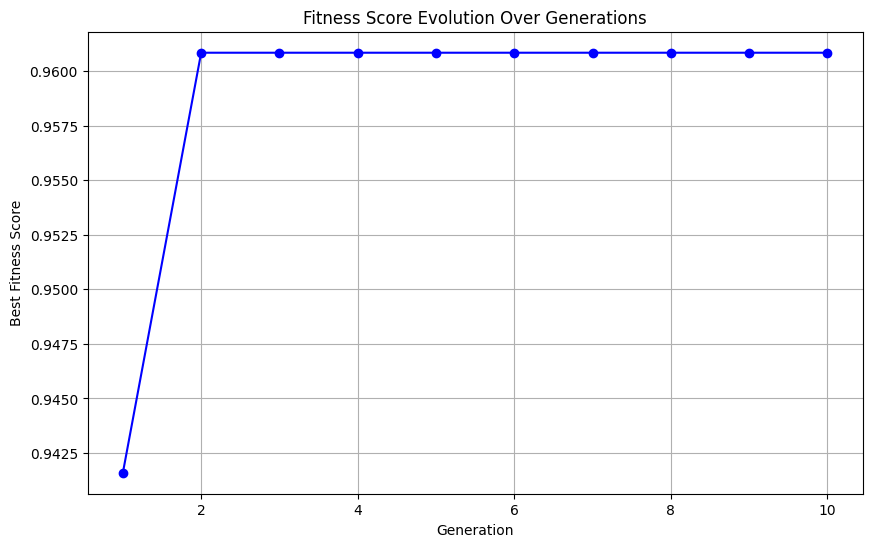

In [8]:
# Initialize parameters for grid search
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Define base estimator
estimator = KNeighborsClassifier()

# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target
feature_names = data.feature_names

# Initialize the SAGAFS_GA class with hyperparameters
saga_fs = SAGAFS_GA(
    estimator=estimator,
    cv=cv,
    scoring='matthews_corrcoef',
    population_size=20,
    generations=10,
    mutation_rate=0.1,
    crossover_rate=0.5,
    param_grid=param_grid,
    lambda_val=0.001
)

# Preprocess the dataset for consistency and scaling
X, y = saga_fs.preprocess_dataset(X, y)

# Fit the evolutionary feature selection model to the Iris dataset
saga_fs.fit(X, y, dataset_name="Iris", output_dir="output_results")

# Visualize fitness evolution across generations
saga_fs.plot_fitness_over_generations()


# Using SAGAFS_GA on every predefined dataset


Processing dataset: Iris
--- Generation 1 ---
Parents: {0}, {3}
Child 1: {0, 3}
Child 2: set()
Parents: {0}, {0}
Child 1: {0}
Child 2: {0}
Parents: {0}, {3}
Child 1: {3}
Child 2: {0}
Parents: {2}, {0}
Child 1: {0, 2}
Child 2: set()
Parents: {2}, {0}
Child 1: {0}
Child 2: {2}
Parents: {2}, {0}
Child 1: {0, 2}
Child 2: set()
Parents: {2}, {1}
Child 1: {2}
Child 2: {1}
Parents: {0}, {0}
Child 1: {0}
Child 2: {0}
Parents: {3}, {3}
Child 1: {3}
Child 2: {3}
Parents: {1}, {2}
Child 1: {1}
Child 2: {2}
--- Generation 2 ---
Parents: {3}, {0}
Child 1: {0}
Child 2: {3}
Parents: {0, 2}, {0, 3}
Child 1: {0, 2}
Child 2: {0, 3}
Parents: {0}, {0, 2}
Child 1: {0}
Child 2: {0, 2}
Parents: {1}, set()
Child 1: set()
Child 2: {1}
Parents: {1}, {0, 1, 3}
Child 1: {1, 3}
Child 2: {0, 1}
Parents: {0, 1, 3}, {1}
Child 1: {0, 1, 3}
Child 2: {1}
Parents: {0}, set()
Child 1: set()
Child 2: {0}
Parents: {0}, {0, 1}
Child 1: {0, 1}
Child 2: {0}
Parents: {2}, set()
Child 1: {2}
Child 2: set()
Parents: set(), {0}
Ch

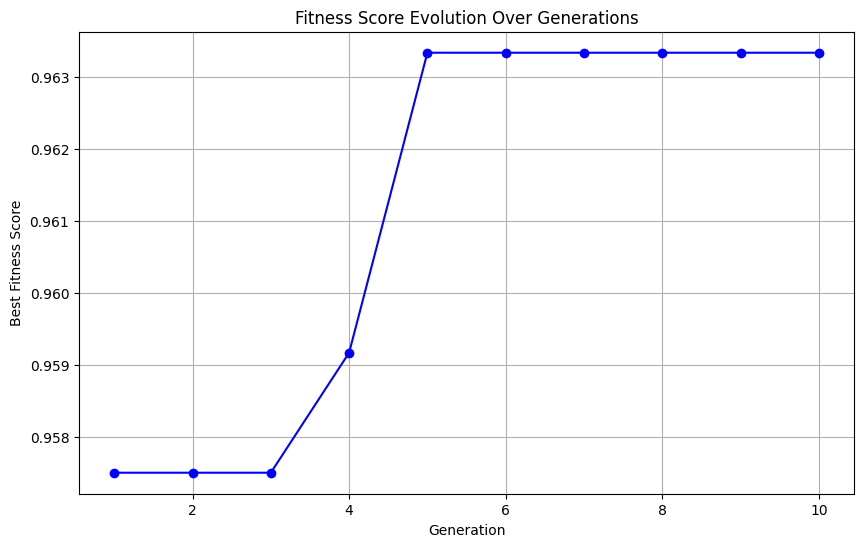

Processing dataset: WBDC (Breast Cancer Wisconsin Diagnostic)
--- Generation 1 ---
Parents: {7, 10, 11, 14, 16, 17, 20}, {23}
Child 1: {7, 10, 11, 17, 20, 23}
Child 2: {16, 14}
Parents: {17, 14}, {18, 22}
Child 1: {17, 18, 14, 22}
Child 2: set()
Parents: {7, 11, 15, 16, 24, 27}, {19, 22}
Child 1: {27, 11}
Child 2: {7, 15, 16, 19, 22, 24}
Parents: {4, 10, 13, 16, 19, 28, 29}, {11, 19, 29}
Child 1: {10, 19, 29}
Child 2: {4, 11, 13, 16, 19, 28, 29}
Parents: {9}, {2, 4, 28, 15}
Child 1: {9, 4}
Child 2: {2, 28, 15}
Parents: {23}, {8, 24, 22}
Child 1: set()
Child 2: {8, 24, 22, 23}
Parents: {3, 6, 23}, {18, 21, 15}
Child 1: {18, 3, 6, 23}
Child 2: {21, 15}
Parents: {8, 13, 29, 6}, {24, 25, 6}
Child 1: {6, 8, 13, 25, 29}
Child 2: {24, 6}
Parents: {10}, {18, 21, 15}
Child 1: {10, 18, 21, 15}
Child 2: set()
Parents: {9}, {18, 22}
Child 1: set()
Child 2: {9, 18, 22}
--- Generation 2 ---
Parents: {4, 8, 12, 14, 15, 22, 23, 24}, {17, 10, 19, 29}
Child 1: {8, 10, 12, 14, 15, 19, 22}
Child 2: {4, 17

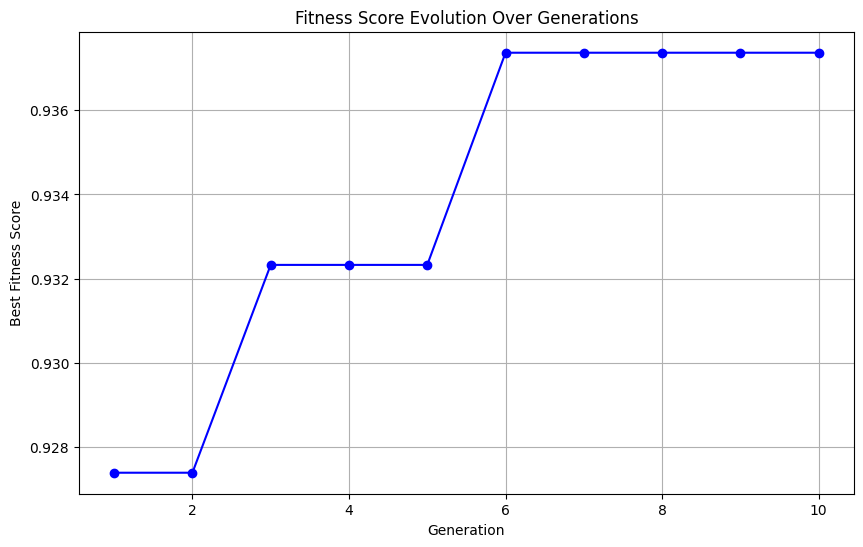

Processing dataset: Spambase
--- Generation 1 ---
Parents: {0, 1, 38, 8, 53, 27}, {1, 6, 47, 50, 51, 21, 56, 24, 26, 27}
Child 1: {0, 1, 6, 47, 50, 51, 56, 27}
Child 2: {1, 38, 8, 53, 21, 24, 26, 27}
Parents: {1, 3, 40, 12, 55}, {35, 36, 38, 11, 44, 45, 13, 16, 18, 25, 29}
Child 1: {35, 36, 38, 11, 12, 44, 45, 13, 16, 18, 55, 25}
Child 2: {40, 1, 3, 29}
Parents: {1, 6, 47, 50, 51, 21, 56, 24, 26, 27}, {8, 9, 27}
Child 1: {8, 9, 47, 51, 24, 26, 27}
Child 2: {1, 6, 50, 21, 56, 27}
Parents: {0, 34, 13, 46, 55, 25}, {0, 34, 35, 37, 7, 41, 10, 18, 55, 25, 26, 28, 30}
Child 1: {0, 34, 35, 41, 10, 46, 55, 25, 26, 30}
Child 2: {0, 34, 37, 7, 13, 18, 55, 25, 28}
Parents: {1, 6, 47, 50, 51, 21, 56, 24, 26, 27}, {24, 56, 43}
Child 1: {1, 26, 6, 43, 50, 21, 24, 56}
Child 2: {47, 51, 24, 56, 27}
Parents: {0, 34, 6, 9, 11, 13, 45, 48, 50, 19, 51, 21, 26}, {41, 42, 9, 12, 47}
Child 1: {0, 9, 41, 47, 50, 51, 26}
Child 2: {34, 6, 9, 42, 11, 12, 13, 45, 48, 19, 21}
Parents: {56, 40}, {34, 36, 38, 40, 9,

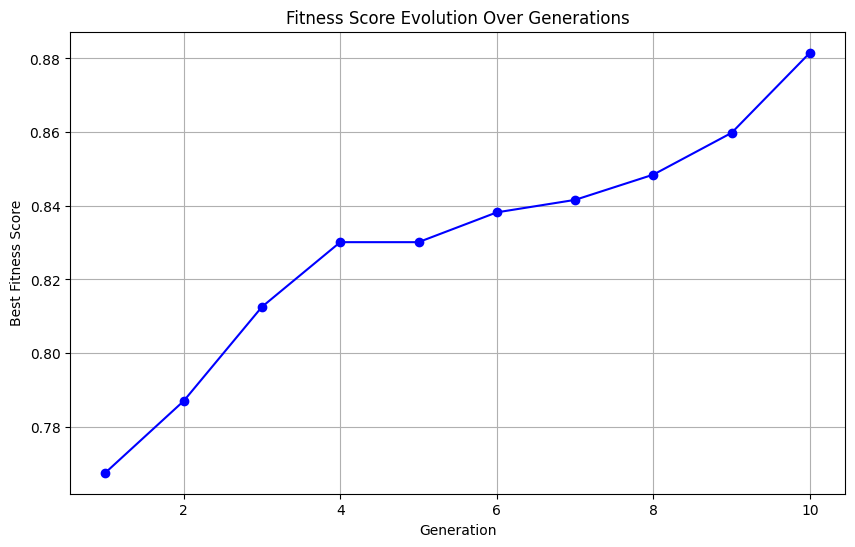

Processing dataset: Heart
--- Generation 1 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {0}, {3}
Child 1: {0}
Child 2: {3}
Parents: {0}, {3}
Child 1: {0}
Child 2: {3}
Parents: {1}, {3}
Child 1: set()
Child 2: {1, 3}
Parents: {2}, {0}
Child 1: set()
Child 2: {0, 2}
Parents: {2}, {3}
Child 1: {2}
Child 2: {3}
Parents: {3}, {2}
Child 1: {2, 3}
Child 2: set()
Parents: {3}, {0}
Child 1: {3}
Child 2: {0}
Parents: {3}, {0}
Child 1: set()
Child 2: {0, 3}
Parents: {3}, {0}
Child 1: {0, 3}
Child 2: set()
Parents: {2}, {0}
Child 1: {2}
Child 2: {0}
--- Generation 2 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {3}, {0}
Child 1: set()
Child 2: {0, 3}
Parents: set(), {3}
Child 1: {3}
Child 2: set()
Parents: {2, 3}, {3}
Child 1: {2, 3}
Child 2: {3}
Parents: {1}, {2, 3}
Child 1: {2, 3}
Child 2: {1}
Parents: {2, 3}, {2}
Child 1: {2, 3}
Child 2: {2}
Parents: {1}, {0, 3}
Child 1: {0, 3}
Child 2: {1}
Parents: {0}, {0, 1}
Child 1: {0, 1}
Child 2: {0}
Parents: {3}, set()
Child 1: set()
Child 2: {3}
Parents: {2, 3}, {3}
Child 1: {3}
Child 2: {2, 3}
Parents: {0, 1}, {0, 3}
Child 1: {0}
Child 2: {0, 1, 3}
--- Generation 3 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {0}, set()
Child 1: set()
Child 2: {0}
Parents: {2, 3}, {2, 3}
Child 1: {2, 3}
Child 2: {2, 3}
Parents: {2, 3}, set()
Child 1: {3}
Child 2: {2}
Parents: {2, 3}, {3}
Child 1: {3}
Child 2: {2, 3}
Parents: {2, 3}, {0}
Child 1: {0, 2}
Child 2: {3}
Parents: {0}, {0}
Child 1: {0}
Child 2: {0}
Parents: {1, 2, 3}, {2, 3}
Child 1: {2, 3}
Child 2: {1, 2, 3}
Parents: set(), {0}
Child 1: {0}
Child 2: set()
Parents: {0}, {3}
Child 1: {0}
Child 2: {3}
Parents: {3}, {3}
Child 1: {3}
Child 2: {3}
--- Generation 4 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {0, 2}, {0}
Child 1: {0, 2}
Child 2: {0}
Parents: {0}, {2, 3}
Child 1: {2, 3}
Child 2: {0}
Parents: {2, 3}, set()
Child 1: {2}
Child 2: {3}
Parents: {3}, {0, 2}
Child 1: {2}
Child 2: {0, 3}
Parents: {1, 2, 3}, {3}
Child 1: {2, 3}
Child 2: {1, 3}
Parents: {3}, {3}
Child 1: {3}
Child 2: {3}
Parents: {2, 3}, {3}
Child 1: {2, 3}
Child 2: {3}
Parents: {1, 2}, {3}
Child 1: {2}
Child 2: {1, 3}
Parents: {2, 3}, {2, 3}
Child 1: {2, 3}
Child 2: {2, 3}
Parents: {1, 2}, set()
Child 1: set()
Child 2: {1, 2}
--- Generation 5 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {1, 3}, {2}
Child 1: {1}
Child 2: {2, 3}
Parents: {0}, {0}
Child 1: {0}
Child 2: {0}
Parents: {3}, {0}
Child 1: {3}
Child 2: {0}
Parents: {0, 2, 3}, {3}
Child 1: {0, 3}
Child 2: {2, 3}
Parents: {2, 3}, {1, 3}
Child 1: {2, 3}
Child 2: {1, 3}
Parents: {2, 3}, {0}
Child 1: {2}
Child 2: {0, 3}
Parents: set(), {1, 3}
Child 1: set()
Child 2: {1, 3}
Parents: {2, 3}, {2}
Child 1: {2, 3}
Child 2: {2}
Parents: {1, 3}, {0, 2, 3}
Child 1: {2, 3}
Child 2: {0, 1, 3}
Parents: set(), {2, 3}
Child 1: {3}
Child 2: {2}
--- Generation 6 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {2}, {1}
Child 1: {1, 2}
Child 2: set()
Parents: {2, 3}, {1, 2, 3}
Child 1: {1, 2, 3}
Child 2: {2, 3}
Parents: {3}, {0, 3}
Child 1: {3}
Child 2: {0, 3}
Parents: {1}, {0}
Child 1: {1}
Child 2: {0}
Parents: {0, 1, 3}, {0, 1, 3}
Child 1: {0, 1, 3}
Child 2: {0, 1, 3}
Parents: {2}, {0, 3}
Child 1: {2, 3}
Child 2: {0}
Parents: {0, 3}, set()
Child 1: {0}
Child 2: {3}
Parents: set(), {0, 3}
Child 1: {0}
Child 2: {3}
Parents: {1}, {0}
Child 1: set()
Child 2: {0, 1}
Parents: {2, 3}, set()
Child 1: {3}
Child 2: {2}
--- Generation 7 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {0, 1, 2, 3}, {1, 2, 3}
Child 1: {1, 2, 3}
Child 2: {0, 1, 2, 3}
Parents: {0}, {0, 3}
Child 1: {0}
Child 2: {0, 3}
Parents: {0}, {3}
Child 1: {0, 3}
Child 2: set()
Parents: {1, 2}, {3}
Child 1: {1, 2, 3}
Child 2: set()
Parents: {1, 2}, {1}
Child 1: {1, 2}
Child 2: {1}
Parents: {3}, {0}
Child 1: set()
Child 2: {0, 3}
Parents: {1}, {3}
Child 1: {3}
Child 2: {1}
Parents: {1}, {1}
Child 1: {1}
Child 2: {1}
Parents: {0, 1, 2, 3}, {0, 3}
Child 1: {0, 2, 3}
Child 2: {0, 1, 3}
Parents: {3}, {1, 2, 3}
Child 1: {3}
Child 2: {1, 2, 3}
--- Generation 8 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: set(), {3}
Child 1: {3}
Child 2: set()
Parents: {1}, {1}
Child 1: {1}
Child 2: {1}
Parents: {0, 3}, {1, 2, 3}
Child 1: {2, 3}
Child 2: {0, 1, 3}
Parents: {0, 1, 2, 3}, {1, 2}
Child 1: {1, 2}
Child 2: {0, 1, 2, 3}
Parents: {0, 3}, {1, 2}
Child 1: {0, 1, 3}
Child 2: {2}
Parents: {1}, {3}
Child 1: set()
Child 2: {1, 3}
Parents: {3}, {1}
Child 1: {3}
Child 2: {1}
Parents: {1}, {3}
Child 1: set()
Child 2: {1, 3}
Parents: set(), {1}
Child 1: {1}
Child 2: set()
Parents: {1}, {0, 2}
Child 1: {1}
Child 2: {0, 2}
--- Generation 9 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {3}, set()
Child 1: set()
Child 2: {3}
Parents: {1, 2}, {1}
Child 1: {1}
Child 2: {1, 2}
Parents: set(), {0, 1, 3}
Child 1: {0, 1}
Child 2: {3}
Parents: {1}, {3}
Child 1: {1}
Child 2: {3}
Parents: set(), set()
Child 1: set()
Child 2: set()
Parents: set(), {3}
Child 1: set()
Child 2: {3}
Parents: set(), {0, 1}
Child 1: set()
Child 2: {0, 1}
Parents: set(), set()
Child 1: set()
Child 2: set()
Parents: {1, 2}, {1, 2, 3}
Child 1: {1, 2, 3}
Child 2: {1, 2}
Parents: {1}, {1, 2, 3}
Child 1: {1, 3}
Child 2: {1, 2}
--- Generation 10 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {0, 1}, set()
Child 1: {0}
Child 2: {1}
Parents: {1}, {0, 3}
Child 1: set()
Child 2: {0, 1, 3}
Parents: {1}, {1}
Child 1: {1}
Child 2: {1}
Parents: {1, 3}, {1}
Child 1: {1, 3}
Child 2: {1}
Parents: {3}, {0, 1}
Child 1: {1, 3}
Child 2: {0}
Parents: {1, 2}, {1}
Child 1: {1, 2}
Child 2: {1}
Parents: set(), {0, 3}
Child 1: {0, 3}
Child 2: set()
Parents: {0, 3}, set()
Child 1: {3}
Child 2: {0}
Parents: {1, 2, 3}, set()
Child 1: {1}
Child 2: {2, 3}
Parents: {1, 2, 3}, {1}
Child 1: {1, 2}
Child 2: {1, 3}
Model performance summary saved to: output_results/Heart/Heart_1/model_performance_summary.csv


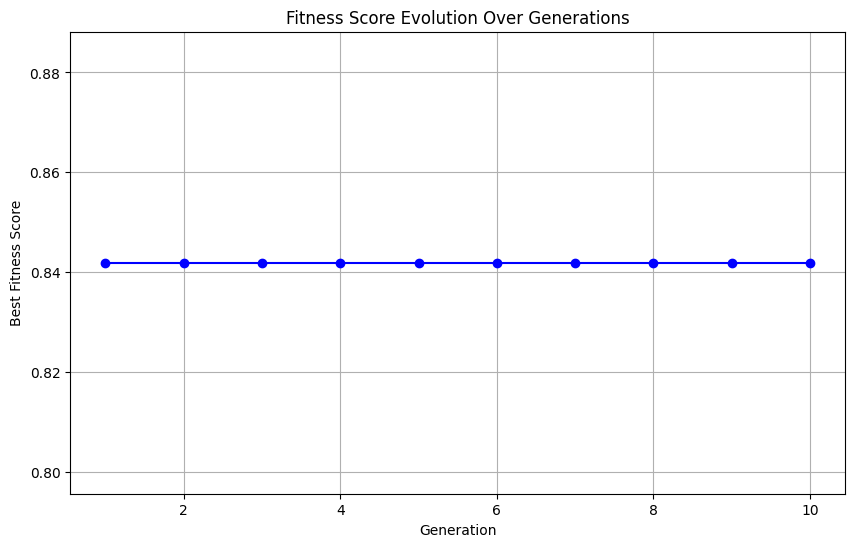

Processing dataset: Glass
--- Generation 1 ---
Parents: {8, 7}, {8, 6}
Child 1: {8, 7}
Child 2: {8, 6}
Parents: {5}, {0, 7}
Child 1: {0, 5}
Child 2: {7}
Parents: {8, 7}, {8, 7}
Child 1: {8, 7}
Child 2: {8, 7}
Parents: {2, 4}, {8, 6}
Child 1: {4, 6}
Child 2: {8, 2}
Parents: {8}, {5}
Child 1: set()
Child 2: {8, 5}
Parents: {8, 4}, {8, 2}
Child 1: {8}
Child 2: {8, 2, 4}
Parents: {3}, {8, 7}
Child 1: {8, 7}
Child 2: {3}
Parents: {5, 7}, {2}
Child 1: {2, 5}
Child 2: {7}
Parents: {0, 7}, {2, 4}
Child 1: {0, 2, 7}
Child 2: {4}
Parents: {5, 7}, {8, 5}
Child 1: {5}
Child 2: {8, 5, 7}
--- Generation 2 ---
Parents: {8, 2}, {8}
Child 1: {8}
Child 2: {8, 2}
Parents: {8}, {5, 7}
Child 1: {8, 7}
Child 2: {5}
Parents: set(), {4}
Child 1: {4}
Child 2: set()
Parents: {1, 3, 6, 7}, {4}
Child 1: {3, 6}
Child 2: {1, 4, 7}
Parents: set(), {0, 4, 5}
Child 1: {4, 5}
Child 2: {0}
Parents: {8}, {8}
Child 1: {8}
Child 2: {8}
Parents: {4, 6}, {2, 5}
Child 1: {4}
Child 2: {2, 5, 6}
Parents: {1, 4, 6}, {8, 2}
Child

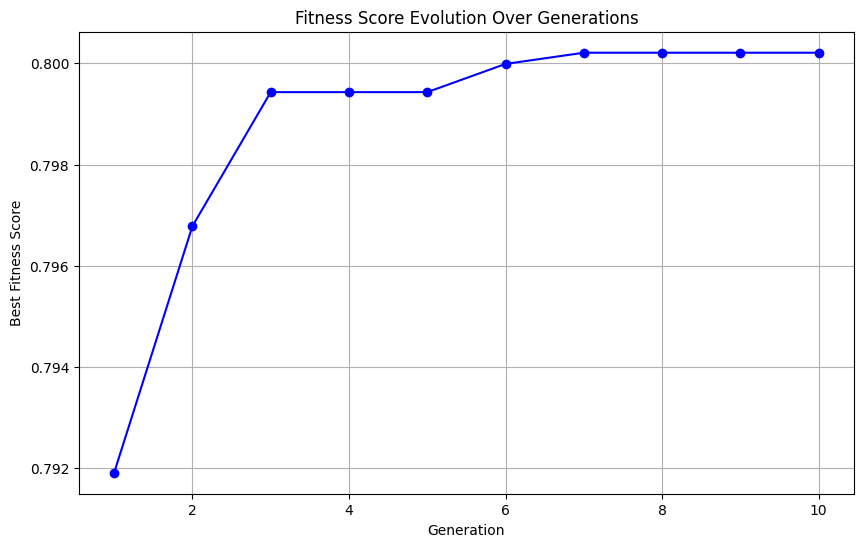

Processing dataset: WBC (Breast Cancer Wisconsin Original)
--- Generation 1 ---
Parents: {0}, {0, 3}
Child 1: {0}
Child 2: {0, 3}
Parents: {0, 6}, {0, 3}
Child 1: {0, 3, 6}
Child 2: {0}
Parents: {3}, {0}
Child 1: {3}
Child 2: {0}
Parents: {6, 7}, {6}
Child 1: {6, 7}
Child 2: {6}
Parents: {1, 7}, {0}
Child 1: set()
Child 2: {0, 1, 7}
Parents: {1, 7}, {2, 7}
Child 1: {2, 7}
Child 2: {1, 7}
Parents: {1, 6}, {4, 6}
Child 1: {6}
Child 2: {1, 4, 6}
Parents: {0}, {1, 6}
Child 1: {0}
Child 2: {1, 6}
Parents: {0}, {1, 7}
Child 1: {0, 1}
Child 2: {7}
Parents: {1, 7}, {6}
Child 1: {1}
Child 2: {6, 7}
--- Generation 2 ---
Parents: {3, 4}, {0}
Child 1: {3}
Child 2: {0, 4}
Parents: {6}, {2, 3, 7}
Child 1: {2, 3}
Child 2: {6, 7}
Parents: {6}, {1, 4}
Child 1: {4}
Child 2: {1, 6}
Parents: {0, 1}, {0, 3}
Child 1: {0, 1}
Child 2: {0, 3}
Parents: {0, 3, 4}, {1, 6}
Child 1: {4, 6}
Child 2: {0, 1, 3}
Parents: {6}, {0, 3}
Child 1: {0, 3}
Child 2: {6}
Parents: {0, 1}, {6, 7}
Child 1: {0, 1}
Child 2: {6, 7}
Pa

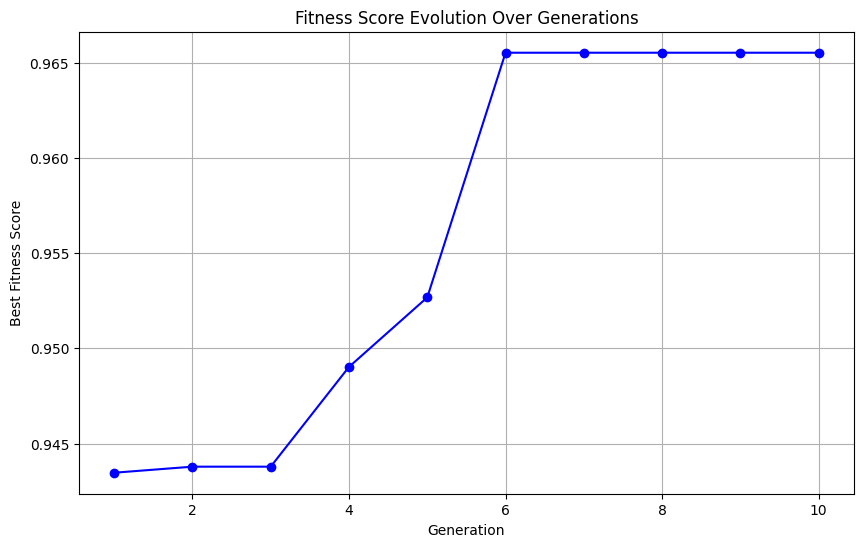

Processing dataset: Ionosphere
--- Generation 1 ---
Parents: {0, 16, 18, 20, 22, 28}, {33, 13, 14, 16, 21, 30}
Child 1: {0, 33, 14, 16, 20, 21, 22, 30}
Child 2: {16, 18, 28, 13}
Parents: {16, 32, 13, 14}, {5, 9, 12, 14, 20, 28, 30}
Child 1: {32, 5, 9, 12, 14, 16}
Child 2: {13, 14, 20, 28, 30}
Parents: {16, 32, 13, 14}, {3, 7, 9, 15, 17, 18, 27}
Child 1: {32, 3, 7, 14, 16, 18, 27}
Child 2: {9, 13, 17, 15}
Parents: {32, 1, 2, 13, 19, 21}, {33, 13, 14, 16, 21, 30}
Child 1: {32, 1, 33, 13, 14, 16, 21, 30}
Child 2: {19, 21, 2, 13}
Parents: {16, 32, 13, 14}, {3, 7, 9, 15, 17, 18, 27}
Child 1: {9, 14, 15, 16, 17, 18}
Child 2: {32, 3, 7, 13, 27}
Parents: {30}, {16, 32, 13, 14}
Child 1: {16, 32, 13, 30}
Child 2: {14}
Parents: {17, 18, 25}, {32, 1, 2, 13, 19, 21}
Child 1: {17, 18, 21, 25}
Child 2: {32, 1, 2, 13, 19}
Parents: {0, 16, 18, 20, 22, 28}, {3, 7, 9, 15, 17, 18, 27}
Child 1: {3, 9, 16, 17, 18, 22, 27, 28}
Child 2: {0, 7, 15, 18, 20}
Parents: {3, 7, 9, 15, 17, 18, 27}, {0, 16, 18, 20, 22

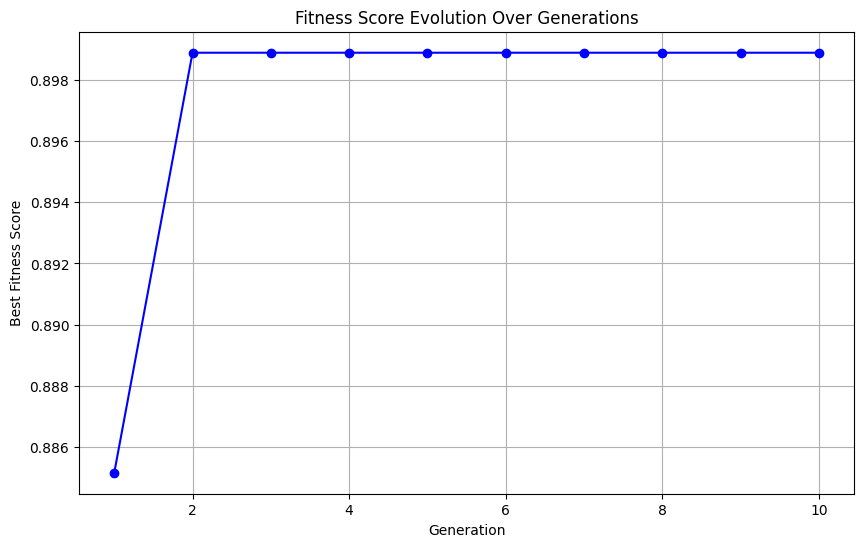

Processing dataset: Arrhythmia
--- Generation 1 ---


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {1, 259, 3, 262, 263, 264, 135, 10, 274, 147, 20, 277, 22, 150, 148, 149, 156, 29, 159, 32, 160, 164, 165, 41, 171, 44, 43, 174, 46, 175, 52, 56, 57, 189, 61, 191, 192, 201, 73, 78, 209, 88, 89, 95, 98, 228, 101, 234, 110, 115, 123, 125, 126}, {194, 195, 26, 164, 230, 71, 229, 136, 10, 7, 140, 269, 275, 21, 181, 122, 95}
Child 1: {1, 259, 262, 263, 264, 135, 10, 140, 274, 147, 20, 277, 22, 150, 148, 21, 26, 159, 32, 164, 165, 171, 44, 174, 56, 57, 61, 192, 71, 73, 78, 209, 89, 95, 98, 101, 229, 110, 125, 126}
Child 2: {3, 7, 136, 10, 269, 275, 149, 156, 29, 160, 164, 41, 43, 46, 175, 52, 181, 189, 191, 194, 195, 201, 88, 95, 228, 230, 234, 115, 122, 123}
Parents: {129, 259, 4, 5, 3, 262, 8, 265, 9, 11, 267, 141, 7, 272, 273, 145, 144, 18, 20, 131, 156, 31, 34, 163, 36, 165, 42, 43, 45, 173, 179, 52, 53, 181, 55, 56, 54, 58, 189, 61, 68, 71, 199, 73, 78, 207, 208, 210, 84, 214, 87, 88, 92, 97, 105, 106, 234, 237, 124, 116, 244, 246, 253, 127, 125, 255}, {128, 257, 4, 132, 266, 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {3, 260, 6, 8, 264, 270, 271, 272, 274, 24, 27, 29, 31, 36, 40, 45, 53, 55, 60, 69, 74, 81, 92, 94, 96, 97, 103, 106, 107, 119, 120, 125, 128, 129, 133, 134, 159, 163, 181, 182, 188, 198, 202, 204, 234, 255}, {1, 129, 131, 130, 6, 263, 138, 267, 12, 270, 275, 20, 150, 26, 154, 27, 28, 155, 159, 160, 164, 36, 38, 170, 171, 44, 172, 174, 177, 49, 182, 58, 59, 188, 61, 62, 65, 194, 197, 201, 77, 208, 211, 87, 217, 247, 220, 223, 224, 97, 100, 233, 236, 244, 118, 119, 123, 124, 253, 127}
Child 1: {129, 1, 3, 260, 131, 6, 134, 8, 264, 263, 138, 270, 271, 272, 274, 20, 24, 27, 155, 29, 28, 159, 31, 36, 164, 38, 40, 171, 44, 45, 172, 174, 49, 181, 182, 55, 58, 188, 61, 65, 194, 197, 201, 202, 204, 208, 87, 217, 247, 220, 94, 96, 97, 100, 233, 236, 244, 118, 119, 120, 253, 125}
Child 2: {128, 129, 130, 133, 6, 267, 12, 270, 275, 150, 154, 27, 26, 159, 160, 163, 36, 170, 177, 53, 182, 59, 60, 188, 62, 69, 198, 74, 77, 81, 211, 92, 223, 224, 97, 103, 106, 107, 234, 127, 119, 123, 124, 2

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {256, 1, 130, 131, 261, 262, 6, 7, 10, 139, 12, 275, 148, 277, 150, 151, 24, 154, 27, 28, 29, 157, 163, 164, 36, 38, 166, 170, 171, 44, 173, 174, 48, 49, 50, 178, 180, 182, 57, 185, 188, 65, 194, 70, 76, 77, 78, 83, 87, 223, 224, 98, 228, 100, 233, 235, 236, 237, 112, 241, 244, 118, 122, 252, 127}, {257, 1, 130, 6, 9, 265, 12, 13, 141, 143, 16, 144, 146, 272, 20, 149, 274, 23, 24, 27, 32, 35, 166, 168, 45, 173, 176, 181, 54, 55, 53, 57, 64, 193, 68, 71, 73, 202, 203, 77, 206, 207, 80, 82, 83, 213, 87, 88, 119, 91, 92, 94, 223, 97, 226, 227, 228, 107, 123, 237, 235, 112, 241, 242, 244, 247, 249, 122, 251, 252}
Child 1: {1, 6, 9, 10, 265, 12, 13, 16, 274, 275, 277, 24, 27, 29, 35, 36, 38, 44, 45, 49, 55, 57, 65, 68, 70, 73, 76, 77, 78, 80, 82, 83, 87, 88, 100, 107, 112, 119, 122, 127, 130, 131, 139, 141, 143, 150, 151, 163, 166, 168, 173, 174, 178, 180, 181, 188, 206, 207, 213, 223, 224, 227, 228, 233, 235, 237, 241, 244, 249, 251, 252}
Child 2: {256, 1, 257, 261, 6, 262, 7, 12,

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {261, 264, 10, 271, 272, 273, 274, 276, 21, 277, 30, 31, 38, 39, 42, 43, 46, 50, 51, 52, 53, 57, 62, 64, 77, 78, 82, 89, 91, 94, 95, 97, 98, 101, 103, 106, 107, 110, 111, 112, 115, 120, 133, 135, 136, 138, 139, 140, 145, 146, 148, 150, 153, 162, 163, 164, 165, 166, 171, 174, 177, 182, 183, 187, 189, 192, 193, 196, 198, 200, 209, 211, 212, 213, 215, 221, 226, 231, 232, 234, 236, 240, 244, 245, 246, 255}, {1, 3, 6, 7, 8, 263, 10, 267, 14, 16, 272, 18, 277, 29, 31, 32, 35, 36, 38, 39, 41, 42, 43, 44, 45, 50, 54, 59, 62, 63, 64, 70, 73, 75, 77, 78, 79, 81, 82, 83, 87, 91, 92, 94, 96, 103, 112, 113, 115, 117, 119, 121, 122, 123, 124, 126, 128, 129, 135, 140, 141, 143, 145, 148, 152, 161, 163, 166, 174, 175, 177, 180, 181, 186, 187, 189, 191, 193, 199, 202, 207, 210, 213, 217, 228, 233, 236, 240, 241, 243, 244, 246, 247, 249, 255}
Child 1: {3, 6, 10, 14, 18, 29, 31, 32, 36, 38, 39, 41, 42, 43, 44, 46, 50, 51, 57, 59, 62, 63, 64, 70, 73, 77, 78, 82, 83, 91, 94, 97, 98, 103, 112, 115,

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {1, 2, 257, 4, 260, 6, 263, 264, 9, 10, 267, 268, 8, 270, 271, 17, 275, 22, 24, 27, 28, 33, 37, 42, 43, 45, 50, 56, 57, 60, 64, 65, 67, 68, 72, 76, 78, 79, 83, 85, 87, 88, 89, 91, 93, 96, 97, 98, 99, 100, 108, 110, 115, 120, 121, 122, 123, 125, 128, 129, 130, 138, 141, 144, 146, 149, 150, 151, 154, 155, 156, 159, 162, 163, 166, 171, 173, 175, 176, 179, 181, 193, 199, 202, 207, 208, 211, 212, 220, 221, 222, 224, 228, 236, 242, 246, 248, 250, 254}, {1, 257, 259, 4, 5, 263, 265, 10, 268, 14, 271, 18, 275, 25, 28, 29, 31, 32, 33, 35, 36, 37, 39, 42, 43, 44, 45, 51, 58, 59, 60, 61, 63, 64, 67, 68, 71, 78, 79, 80, 83, 84, 85, 91, 92, 94, 96, 99, 103, 105, 111, 112, 113, 114, 119, 124, 125, 126, 127, 128, 140, 141, 142, 143, 144, 145, 146, 150, 152, 161, 164, 172, 174, 175, 177, 180, 183, 184, 186, 188, 189, 193, 195, 197, 199, 202, 208, 210, 214, 218, 227, 228, 230, 236, 240, 241, 243, 244, 245}
Child 1: {1, 2, 4, 5, 10, 17, 24, 27, 28, 29, 31, 32, 33, 37, 42, 43, 44, 45, 58, 60, 63

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {256, 257, 2, 260, 6, 263, 264, 270, 271, 17, 275, 20, 22, 24, 27, 28, 33, 34, 42, 43, 45, 50, 54, 55, 56, 58, 64, 65, 66, 67, 68, 72, 73, 75, 78, 79, 83, 87, 88, 89, 96, 97, 99, 100, 101, 103, 108, 118, 120, 121, 122, 123, 125, 130, 131, 136, 141, 142, 144, 146, 149, 150, 151, 152, 153, 155, 156, 159, 162, 163, 169, 171, 172, 173, 175, 176, 181, 186, 192, 193, 196, 199, 202, 205, 207, 210, 218, 220, 221, 228, 242, 244, 246, 247, 248, 251, 254}, {256, 257, 2, 4, 260, 6, 261, 9, 262, 264, 267, 13, 14, 269, 270, 271, 18, 274, 21, 277, 15, 24, 16, 26, 27, 5, 29, 32, 33, 36, 37, 41, 43, 49, 50, 51, 54, 265, 56, 58, 59, 61, 62, 63, 66, 70, 73, 75, 78, 80, 81, 82, 83, 85, 17, 87, 92, 97, 100, 103, 104, 106, 108, 110, 111, 112, 113, 115, 118, 120, 122, 123, 126, 128, 129, 132, 133, 139, 141, 151, 152, 154, 156, 159, 160, 162, 167, 171, 173, 175, 177, 181, 182, 185, 186, 189, 191, 193, 194, 196, 197, 199, 201, 207, 215, 218, 222, 228, 230, 232, 239, 241, 242, 243, 244, 245, 247, 249, 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {256, 2, 3, 4, 5, 6, 260, 262, 267, 270, 271, 16, 17, 273, 20, 276, 277, 278, 24, 27, 29, 33, 34, 36, 37, 41, 43, 50, 54, 56, 58, 59, 61, 63, 65, 66, 67, 68, 70, 74, 75, 78, 81, 82, 83, 85, 87, 88, 89, 97, 98, 101, 103, 104, 108, 110, 112, 115, 118, 120, 122, 123, 126, 131, 133, 141, 144, 151, 152, 153, 154, 155, 156, 160, 162, 163, 167, 169, 171, 173, 175, 176, 182, 185, 186, 190, 191, 193, 194, 196, 197, 199, 206, 207, 210, 215, 218, 220, 221, 225, 231, 232, 235, 239, 241, 242, 243, 244, 247, 248, 251}, {256, 1, 257, 2, 3, 261, 262, 6, 7, 9, 10, 11, 268, 260, 14, 271, 274, 20, 278, 23, 24, 25, 34, 36, 42, 43, 44, 45, 46, 47, 48, 49, 57, 66, 67, 72, 76, 82, 83, 84, 90, 94, 102, 103, 104, 107, 108, 109, 115, 119, 120, 121, 122, 124, 127, 129, 132, 135, 137, 145, 152, 153, 154, 155, 156, 161, 162, 164, 167, 172, 173, 174, 179, 180, 181, 183, 188, 198, 204, 206, 227, 232, 235, 236, 238, 240, 242, 244, 246, 247, 250, 252}
Child 1: {2, 3, 4, 5, 6, 9, 11, 14, 20, 24, 25, 34, 36, 37

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {256, 258, 4, 6, 7, 260, 261, 10, 11, 12, 13, 14, 263, 16, 273, 274, 275, 20, 277, 278, 21, 24, 27, 28, 33, 35, 37, 39, 47, 48, 50, 51, 57, 59, 61, 62, 64, 65, 66, 267, 68, 71, 72, 73, 76, 78, 82, 83, 84, 87, 89, 90, 91, 93, 96, 97, 98, 101, 103, 109, 110, 111, 115, 118, 120, 122, 124, 127, 128, 129, 130, 136, 137, 140, 142, 145, 146, 149, 150, 151, 152, 154, 159, 163, 164, 165, 169, 172, 173, 175, 176, 177, 178, 180, 182, 185, 190, 192, 194, 196, 198, 203, 206, 207, 208, 211, 212, 216, 222, 223, 227, 229, 230, 232, 235, 238, 241, 242, 247, 248, 249, 250, 253, 254}, {256, 1, 3, 261, 6, 7, 8, 263, 262, 264, 274, 24, 31, 33, 39, 43, 44, 45, 48, 49, 51, 54, 57, 59, 62, 64, 72, 73, 76, 77, 78, 85, 87, 92, 94, 99, 101, 103, 104, 106, 108, 112, 114, 118, 119, 120, 122, 123, 125, 126, 127, 128, 138, 139, 141, 143, 147, 148, 152, 156, 157, 162, 164, 165, 171, 174, 175, 176, 178, 180, 183, 184, 186, 188, 192, 198, 205, 206, 208, 209, 210, 213, 215, 217, 218, 220, 224, 227, 232, 234, 23

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {256, 1, 131, 261, 262, 10, 19, 275, 148, 22, 24, 154, 34, 35, 163, 164, 38, 170, 45, 173, 48, 49, 180, 182, 57, 194, 68, 70, 77, 206, 82, 217, 90, 218, 94, 223, 99, 227, 228, 102, 235, 237, 120, 252, 127}, {256, 257, 1, 258, 261, 262, 6, 264, 9, 10, 267, 13, 14, 271, 16, 15, 274, 275, 20, 269, 22, 23, 24, 27, 34, 35, 36, 43, 45, 48, 49, 55, 57, 58, 59, 60, 68, 75, 77, 78, 80, 82, 84, 86, 92, 94, 97, 102, 104, 107, 108, 109, 110, 111, 112, 113, 115, 118, 120, 122, 127, 129, 138, 145, 148, 150, 154, 155, 158, 161, 164, 173, 175, 176, 177, 179, 180, 181, 182, 185, 186, 188, 190, 204, 206, 213, 223, 226, 235, 236, 237, 239, 240, 246, 247, 249}
Child 1: {256, 1, 258, 261, 262, 264, 10, 13, 14, 271, 16, 15, 274, 275, 19, 20, 22, 24, 34, 35, 38, 45, 48, 49, 57, 58, 59, 60, 68, 75, 77, 80, 82, 84, 90, 92, 94, 102, 104, 107, 108, 110, 111, 115, 118, 120, 122, 127, 129, 138, 145, 148, 154, 158, 161, 163, 164, 173, 176, 180, 181, 182, 186, 188, 204, 206, 217, 218, 223, 226, 227, 235, 23

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Parents: {256, 1, 3, 260, 262, 10, 266, 269, 15, 271, 17, 277, 23, 24, 25, 26, 31, 32, 35, 37, 47, 48, 49, 52, 53, 54, 57, 60, 63, 64, 68, 71, 76, 77, 79, 84, 85, 86, 91, 92, 93, 97, 99, 101, 103, 105, 106, 108, 110, 112, 113, 114, 117, 118, 119, 121, 123, 126, 128, 129, 131, 135, 142, 143, 152, 155, 159, 161, 162, 164, 167, 168, 169, 173, 174, 175, 176, 177, 180, 182, 183, 190, 191, 194, 197, 198, 199, 202, 206, 208, 217, 219, 221, 224, 225, 227, 229, 233, 234, 235, 236, 240, 241, 242, 244, 247, 249, 254}, {256, 258, 4, 260, 261, 262, 263, 9, 10, 11, 264, 268, 265, 267, 16, 17, 18, 19, 275, 21, 278, 270, 24, 25, 27, 28, 29, 30, 31, 33, 36, 37, 43, 44, 45, 49, 52, 54, 55, 57, 65, 66, 71, 73, 77, 81, 83, 85, 87, 88, 272, 90, 92, 94, 95, 99, 101, 102, 103, 104, 110, 113, 116, 119, 122, 125, 127, 128, 129, 132, 134, 137, 141, 152, 153, 156, 159, 162, 164, 172, 173, 175, 178, 179, 185, 188, 189, 192, 194, 195, 197, 200, 207, 210, 213, 215, 217, 236, 237, 239, 240, 247, 249, 253, 254}
Child

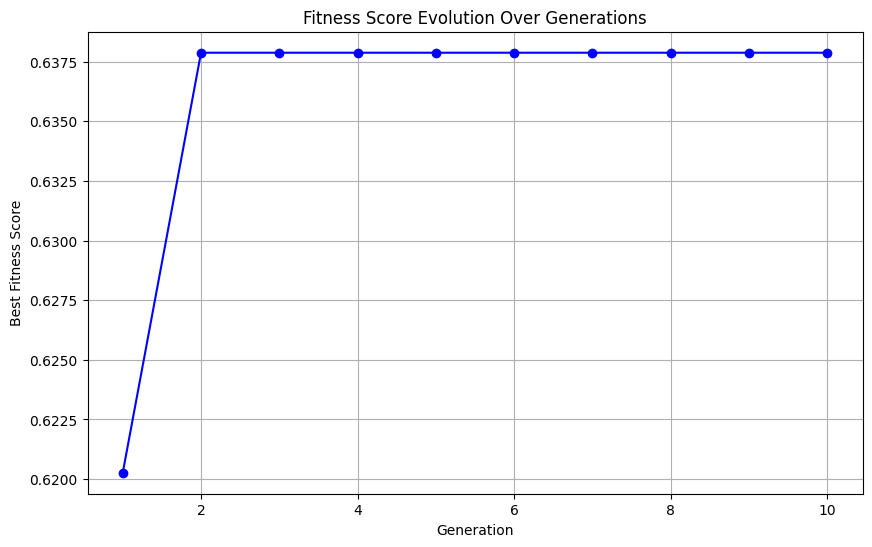

Processing dataset: Multiple Features
--- Generation 1 ---
Parents: {128, 2, 131, 4, 3, 8, 139, 23, 154, 167, 168, 46, 175, 179, 181, 184, 186, 194, 81, 84, 91, 98, 101, 114}, {1, 8, 201, 212, 213, 150, 151, 91, 95}
Child 1: {128, 1, 2, 3, 4, 8, 23, 151, 154, 167, 168, 46, 179, 181, 186, 201, 81, 84, 212, 91, 95, 98, 114}
Child 2: {194, 131, 101, 8, 139, 175, 213, 150, 184, 91}
Parents: {128, 2, 131, 4, 3, 8, 139, 23, 154, 167, 168, 46, 175, 179, 181, 184, 186, 194, 81, 84, 91, 98, 101, 114}, {160, 3, 5, 69, 39, 202, 74, 205, 81, 145, 147, 84, 93, 120, 61}
Child 1: {160, 2, 3, 131, 4, 39, 202, 46, 81, 145, 147, 84, 181, 93, 23, 186, 61}
Child 2: {128, 3, 5, 8, 139, 154, 167, 168, 175, 179, 184, 194, 69, 74, 205, 81, 84, 91, 98, 101, 114, 120}
Parents: {4, 132, 38, 10, 13, 147, 23}, {128, 67, 99, 5, 6, 201, 138, 206, 79, 213, 181, 25, 88, 89, 124, 158}
Child 1: {99, 132, 4, 38, 10, 13, 79, 23, 88, 25, 158}
Child 2: {128, 67, 5, 6, 201, 138, 206, 147, 213, 181, 89, 124}
Parents: {4, 132,

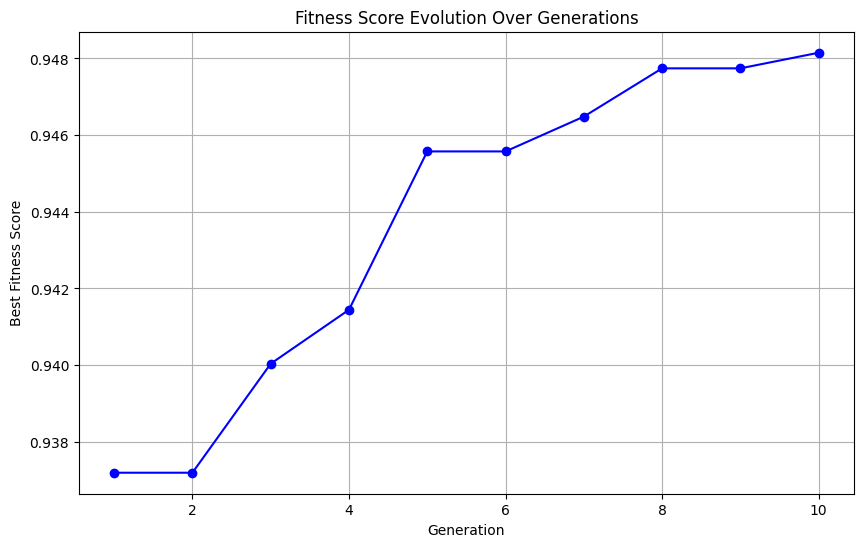

Processing dataset: Australian
--- Generation 1 ---
Parents: {13, 7}, {1}
Child 1: set()
Child 2: {1, 13, 7}
Parents: {2, 12, 13}, {0, 4, 12}
Child 1: {12, 4}
Child 2: {0, 2, 12, 13}
Parents: {8, 0, 4}, {1, 7}
Child 1: {0, 7}
Child 2: {8, 1, 4}
Parents: {4, 13, 7}, {9, 12}
Child 1: {7}
Child 2: {9, 12, 4, 13}
Parents: {3, 5}, {2}
Child 1: {3, 5}
Child 2: {2}
Parents: {4, 13, 7}, {8, 11, 13}
Child 1: {8, 13}
Child 2: {11, 4, 13, 7}
Parents: {8, 9, 7}, {4, 13, 7}
Child 1: {8, 13, 7}
Child 2: {9, 4, 7}
Parents: {10, 4}, {0, 4, 12}
Child 1: {0, 4}
Child 2: {10, 4, 12}
Parents: {8, 0, 4}, {1}
Child 1: {1}
Child 2: {8, 0, 4}
Parents: {2, 12, 13}, {9, 12}
Child 1: {9, 12, 13}
Child 2: {2, 12}
--- Generation 2 ---
Parents: {2}, {2}
Child 1: {2}
Child 2: {2}
Parents: {4, 7, 9, 11, 13}, {0, 9, 7}
Child 1: {0, 9, 11, 7}
Child 2: {9, 4, 13, 7}
Parents: {5, 13, 12, 4}, {1, 5}
Child 1: {1, 4, 5}
Child 2: {13, 12, 5}
Parents: {10, 4, 12}, {12, 7}
Child 1: {12, 4}
Child 2: {10, 12, 7}
Parents: {8, 1, 

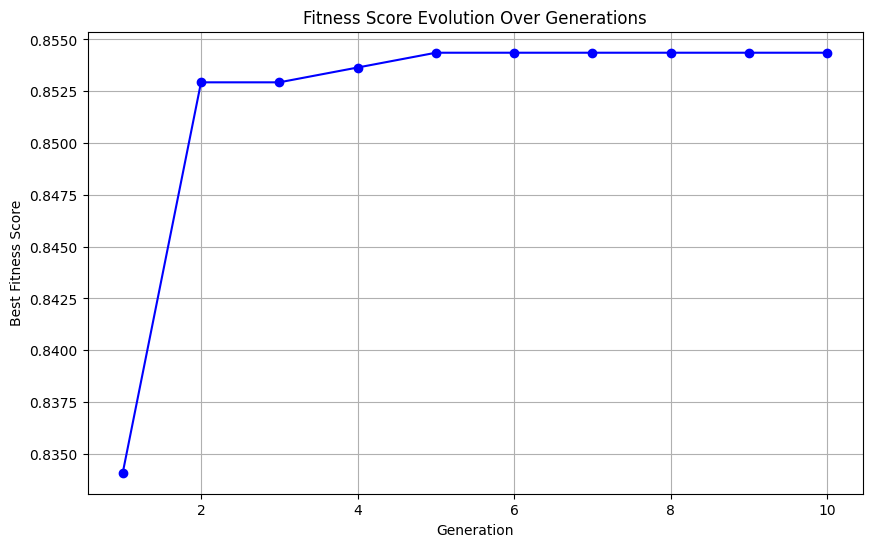

Processing dataset: DNA
--- Generation 1 ---
Parents: {1, 130, 4, 135, 145, 146, 150, 25, 155, 156, 157, 161, 163, 168, 41, 47, 58, 66, 70, 85, 90, 100, 102, 104, 112, 114, 120, 123, 127}, {128, 134, 13, 147, 23, 29, 159, 32, 31, 160, 37, 39, 168, 167, 42, 171, 45, 174, 46, 49, 57, 58, 59, 60, 62, 64, 72, 79, 80, 83, 87, 94, 102, 118, 123}
Child 1: {1, 130, 134, 145, 146, 25, 29, 157, 159, 161, 163, 37, 168, 42, 47, 58, 59, 60, 72, 79, 83, 87, 90, 100, 102, 104, 118, 123, 127}
Child 2: {128, 4, 135, 13, 147, 150, 23, 155, 156, 31, 32, 160, 39, 168, 41, 167, 171, 45, 174, 46, 49, 57, 58, 62, 64, 66, 70, 80, 85, 94, 102, 112, 114, 120, 123}
Parents: {2, 9, 137, 15, 21, 24, 153, 155, 28, 157, 39, 45, 175, 176, 177, 52, 69, 71, 82, 92, 97, 101, 104, 108, 116, 127}, {128, 134, 13, 147, 23, 29, 159, 32, 31, 160, 37, 39, 168, 167, 42, 171, 45, 174, 46, 49, 57, 58, 59, 60, 62, 64, 72, 79, 80, 83, 87, 94, 102, 118, 123}
Child 1: {134, 9, 13, 15, 147, 23, 24, 153, 157, 31, 37, 39, 168, 42, 171, 

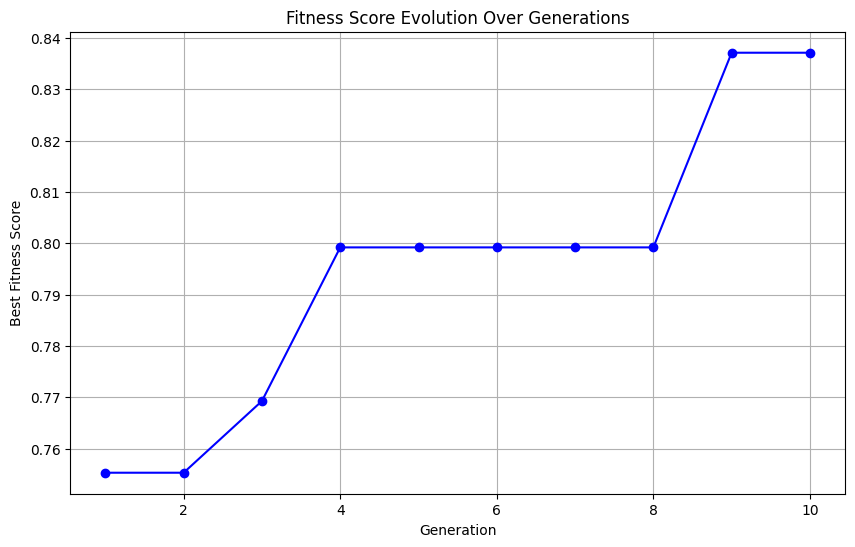

Processing dataset: Wine
--- Generation 1 ---
Parents: {10, 5}, {3, 5, 6}
Child 1: {10, 5, 6}
Child 2: {3, 5}
Parents: {0, 11, 6}, {1, 10, 12}
Child 1: {0, 10, 11, 6}
Child 2: {1, 12}
Parents: {9, 2}, {1, 7}
Child 1: {9, 2, 1}
Child 2: {7}
Parents: {1}, {10, 5}
Child 1: {1, 10}
Child 2: {5}
Parents: {1, 10, 12}, {4, 7}
Child 1: {10, 7}
Child 2: {1, 12, 4}
Parents: {0, 1}, {9}
Child 1: {9}
Child 2: {0, 1}
Parents: {11}, {5, 7}
Child 1: {11}
Child 2: {5, 7}
Parents: {2, 4}, {4}
Child 1: {2, 4}
Child 2: {4}
Parents: {4, 7}, {9, 2}
Child 1: set()
Child 2: {9, 2, 4, 7}
Parents: {4}, {1}
Child 1: {1, 4}
Child 2: set()
--- Generation 2 ---
Parents: {9, 2, 4}, set()
Child 1: {9, 2}
Child 2: {4}
Parents: {9}, {10, 4, 5}
Child 1: {9, 5}
Child 2: {10, 4}
Parents: {10, 3, 5, 6}, {0, 11, 6}
Child 1: {0, 3, 6, 10, 11}
Child 2: {5, 6}
Parents: {0, 11, 6}, {1, 6, 7, 8, 10}
Child 1: {0, 8, 6, 1}
Child 2: {10, 11, 6, 7}
Parents: {1, 2}, {10, 3, 5, 6}
Child 1: {1, 2, 3}
Child 2: {10, 5, 6}
Parents: {1, 6

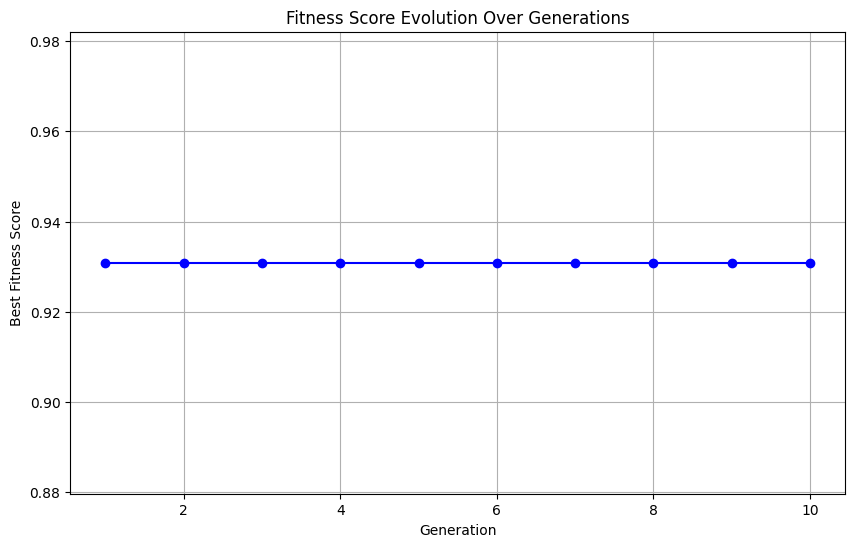

Processing dataset: Vehicle
--- Generation 1 ---
Parents: {5}, {0, 11}
Child 1: {0, 11}
Child 2: {5}
Parents: {2, 11, 13, 14}, {10, 11, 7}
Child 1: {10, 2, 11, 7}
Child 2: {11, 13, 14}
Parents: {5}, {0, 11}
Child 1: {11, 5}
Child 2: {0}
Parents: {9}, {12, 4, 13}
Child 1: {4}
Child 2: {9, 12, 13}
Parents: {5, 15}, {8, 13}
Child 1: {8, 5}
Child 2: {13, 15}
Parents: {9}, {5}
Child 1: set()
Child 2: {9, 5}
Parents: {10, 4, 15}, {10, 11, 7}
Child 1: {10, 11, 7, 15}
Child 2: {10, 4}
Parents: {12}, {10, 11, 7}
Child 1: {12, 7}
Child 2: {10, 11}
Parents: {8}, {9, 10, 6}
Child 1: {8}
Child 2: {9, 10, 6}
Parents: {8}, {2, 11, 13, 14}
Child 1: {8, 11}
Child 2: {2, 13, 14}
--- Generation 2 ---
Parents: {0, 2, 11}, {8, 2}
Child 1: {8, 2}
Child 2: {0, 2, 11}
Parents: {7, 8, 10, 11, 15}, {2, 11, 13, 14}
Child 1: {2, 10, 11, 14}
Child 2: {7, 8, 11, 13, 15}
Parents: {17, 4, 14}, {2, 12, 13, 14, 17}
Child 1: {2, 12, 13, 14, 17}
Child 2: {17, 4, 14}
Parents: {10, 11, 7}, {8, 2}
Child 1: {8, 7}
Child 2: {

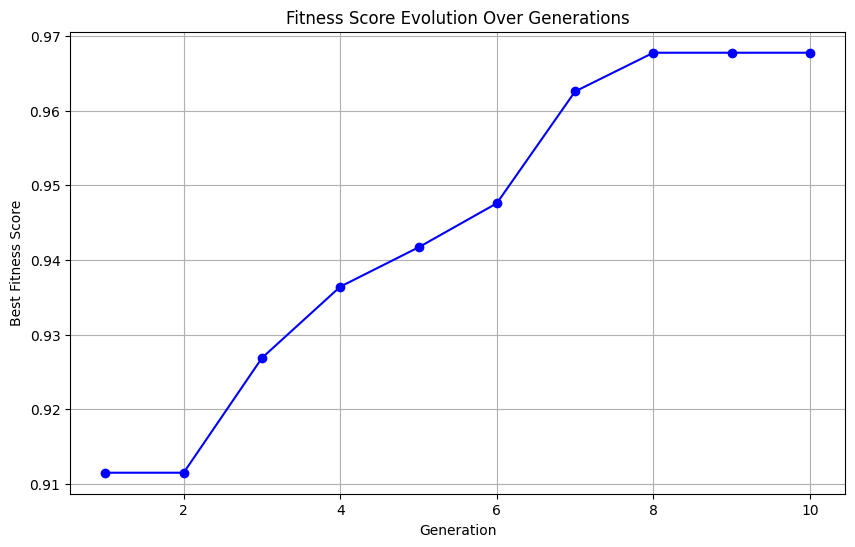

Processing dataset: Waveform
--- Generation 1 ---
Parents: {0, 32, 15, 22, 26, 29}, {34, 5, 37, 24, 30}
Child 1: {24, 29, 30}
Child 2: {0, 32, 34, 37, 5, 15, 22, 26}
Parents: {0, 32, 15, 22, 26, 29}, {18}
Child 1: {32, 22}
Child 2: {0, 15, 18, 26, 29}
Parents: {35, 7, 10, 11, 15, 17, 21, 26, 31}, {0, 11, 13, 14, 15, 18, 27, 28, 30, 31}
Child 1: {0, 35, 7, 10, 11, 14, 15, 17, 18, 26, 31}
Child 2: {11, 13, 15, 21, 27, 28, 30, 31}
Parents: {0, 32, 15, 22, 26, 29}, {6, 22, 26, 27, 29}
Child 1: {6, 15, 22, 26, 29}
Child 2: {0, 32, 22, 26, 27, 29}
Parents: {2, 13, 6}, {18}
Child 1: {13}
Child 2: {2, 18, 6}
Parents: {33, 35, 22, 25}, {3, 11, 12, 14, 25}
Child 1: {35, 3, 11, 14, 22, 25}
Child 2: {25, 12, 33}
Parents: {33, 35, 22, 25}, {3, 11, 12, 14, 25}
Child 1: {25, 3, 12}
Child 2: {33, 35, 11, 14, 22, 25}
Parents: {6, 22, 26, 27, 29}, {18}
Child 1: {6, 18, 26, 27, 29}
Child 2: {22}
Parents: {33, 10, 12, 19, 20, 26, 27, 29}, {27}
Child 1: {10, 12, 19, 20, 26, 27}
Child 2: {33, 27, 29}
Parent

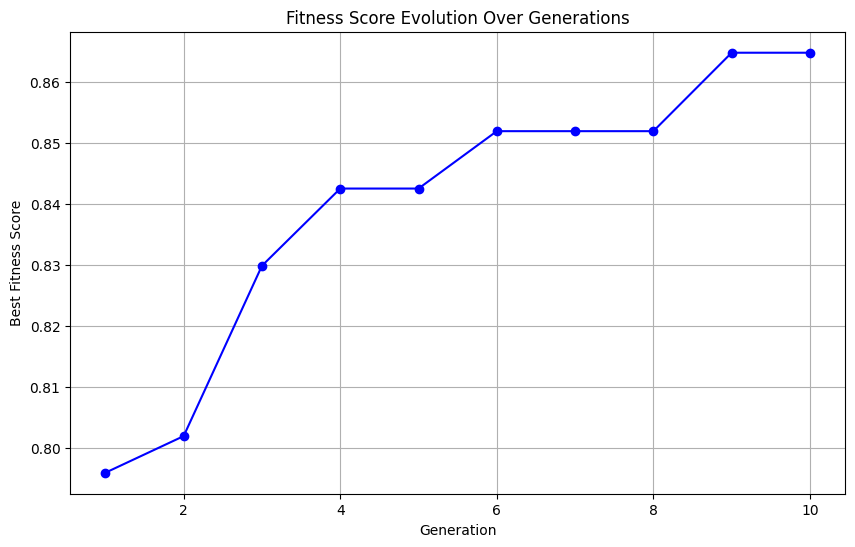

Processing dataset: Hillvalley
--- Generation 1 ---
Parents: {33, 65, 36, 39, 10, 44, 56, 89, 61}, {74}
Child 1: {65, 33, 36, 39, 74, 44, 89, 61}
Child 2: {56, 10}
Parents: {96, 32, 1, 10, 11, 76, 45, 46, 14, 30, 58, 29, 62, 95}, {7, 41, 44, 46, 50, 85, 89, 91, 60}
Child 1: {96, 41, 10, 76, 45, 46, 89, 91, 29, 62, 95}
Child 2: {32, 1, 7, 11, 44, 46, 14, 50, 85, 58, 60, 30}
Parents: {66, 36, 8, 11, 44, 45, 77, 15, 46, 16, 82, 21, 25, 59, 29, 31}, {67, 5, 47, 81, 51, 84, 54, 59, 60, 62}
Child 1: {66, 8, 44, 46, 15, 81, 82, 21, 59, 62}
Child 2: {67, 36, 5, 11, 77, 45, 47, 16, 51, 84, 54, 25, 59, 60, 29, 31}
Parents: {9, 46, 50, 55, 25, 30}, {68}
Child 1: {9, 30}
Child 2: {68, 46, 50, 55, 25}
Parents: {24, 95, 31}, {33, 65, 36, 39, 10, 44, 56, 89, 61}
Child 1: {65, 33, 39, 56, 31, 61, 95}
Child 2: {36, 10, 44, 24, 89}
Parents: {68}, {74}
Child 1: {68}
Child 2: {74}
Parents: {66, 36, 8, 11, 44, 45, 77, 15, 46, 16, 82, 21, 25, 59, 29, 31}, {33, 66, 34, 37, 69, 9, 12, 14, 46, 18, 83, 20, 54, 

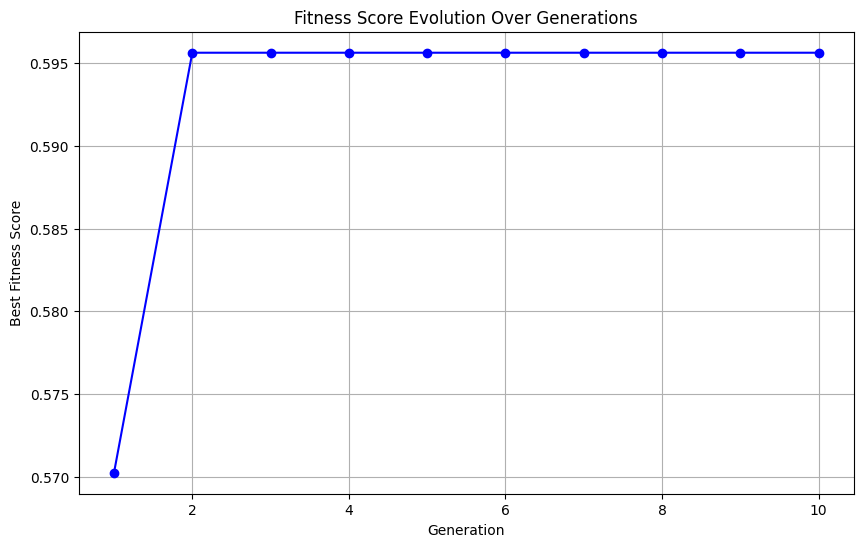

Processing dataset: Sonar
--- Generation 1 ---
Parents: {0, 1, 2, 35, 6, 8, 9, 12, 14, 50, 19, 18, 24}, {1, 36, 38, 8, 40, 12, 53, 23, 58, 29}
Child 1: {1, 2, 6, 8, 40, 12, 18, 19, 53, 23, 29}
Child 2: {0, 1, 35, 36, 38, 8, 9, 12, 14, 50, 24, 58}
Parents: {56}, {0, 2, 37, 8, 42, 12, 48, 25}
Child 1: {2, 8, 42, 48, 25}
Child 2: {56, 0, 12, 37}
Parents: {0, 33, 1, 34, 37, 6, 42, 13, 45, 48, 17, 50, 56, 31}, {33, 2, 3, 4, 7}
Child 1: {0, 33, 1, 2, 4, 37, 6, 48, 31}
Child 2: {33, 34, 3, 7, 42, 45, 13, 17, 50, 56}
Parents: {0, 33, 1, 34, 37, 6, 42, 13, 45, 48, 17, 50, 56, 31}, {8, 50, 47}
Child 1: {33, 34, 1, 37, 6, 13, 45, 48, 17, 50, 56}
Child 2: {0, 8, 42, 47, 50, 31}
Parents: {0, 2, 37, 8, 42, 12, 48, 25}, {31}
Child 1: {0, 2, 42, 48, 25, 31}
Child 2: {8, 12, 37}
Parents: {1, 2, 35, 4, 3, 33, 39, 45, 15, 18, 20, 57}, {31}
Child 1: {57, 2, 35, 39}
Child 2: {1, 33, 3, 4, 45, 15, 18, 20, 31}
Parents: {0, 32, 35, 37, 7, 59, 12, 46, 47, 48, 17, 54, 27}, {36, 7, 42, 51, 54, 59}
Child 1: {0, 3

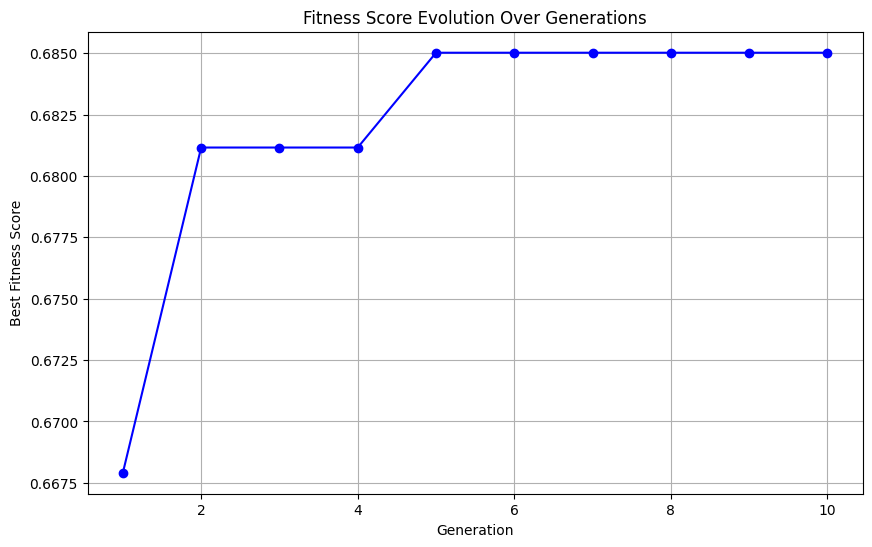

In [9]:
# Initialize parameters for grid search
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Define base estimator
estimator = KNeighborsClassifier()

# Loop through datasets
for dataset_name, dataset_loader in datasets:
    print(f"Processing dataset: {dataset_name}")

    # Load and prepare the dataset
    try:
        data = dataset_loader()
        X, y = data.data, data.target
        feature_names = (
            data.feature_names if hasattr(data, "feature_names")
            else [f"Feature {i}" for i in range(X.shape[1])]
        )
    except Exception as e:
        print(f"Failed to load {dataset_name}: {e}")
        continue

    # Initialize the SAGAFS_GA class with hyperparameters
    saga_fs = SAGAFS_GA(
        estimator=estimator,
        cv=cv,
        scoring='accuracy',
        population_size=20,
        generations=10,
        mutation_rate=0.1,
        crossover_rate=0.5,
        param_grid=param_grid,
        lambda_val=0.01
    )

    # Preprocess the dataset for consistency and scaling
    X, y = saga_fs.preprocess_dataset(X, y)

    # Fit the evolutionary feature selection model
    try:
        saga_fs.fit(X, y, dataset_name=dataset_name, output_dir="output_results")

        # Visualize fitness evolution across generations
        saga_fs.plot_fitness_over_generations()

    except Exception as e:
        print(f"Failed to process {dataset_name}: {e}")
